In [ ]:
#10/1/2021-10/20/2021 Image Extraction

#specify geometry for the location of interest
geojson_geometry = {
  "type": "Point",
      "coordinates": [ 
          -80.010969, 40.442068
      ]
}

#set API filters
geometry_filter = {
  "type": "GeometryFilter",
  "field_name": "geometry",
  "config": geojson_geometry
}
date_range_filter = {
  "type": "DateRangeFilter",
  "field_name": "acquired",
  "config": {
    "gte": "2021-10-01T00:00:00.000Z",
    "lte": "2021-10-20T00:00:00.000Z"
  }
}
cloud_cover_filter = {
  "type": "RangeFilter",
  "field_name": "cloud_cover",
  "config": {
    "lte": 0.10  #10% or less of cloud coverage
  }
}
combined_filter = {
  "type": "AndFilter",
  "config": [geometry_filter, date_range_filter, cloud_cover_filter]
}


# store API Key as an env variable
PLANET_API_KEY = 'PLAKcdca1c45b7d4410ca6697cbb6bd0085a'

#define PSScene to specify we want to query PSScene (Planet Scope Scene)
item_type = "PSScene"

#finalize search_request dict
search_request = {
  "item_types": [item_type], 
  "filter": combined_filter
}

#fire off a .post() request to the Planet server with API link and search_request dict
search_result = requests.post(
    'https://api.planet.com/data/v1/quick-search',
    auth=HTTPBasicAuth(PLANET_API_KEY, ''),
    json=search_request)

#extract the metadata of possible images that fit our query as a json
results = search_result.json()

# extract image IDs only
image_ids = [feature['id'] for feature in results['features']]
image_ids

In [ ]:
#respecify the result to include path for the image we want only
result = requests.get(
    'https://api.planet.com/data/v1/item-types/{}/items/{}/assets'.format(item_type, image_ids[0]),
    auth=HTTPBasicAuth(PLANET_API_KEY, '')
  )

#obtain the asset types available for this particular satellite image to know which composite image to request
print(result.json().keys())

In [ ]:
#check if it has been activated
print(result.json()['ortho_analytic_4b']['status'])

In [ ]:
# Parse out useful links for the activation link for the image asset
links = result.json()[u"ortho_analytic_4b"]["_links"]
self_link = links["_self"]
activation_link = links["activate"]

# Request activation of the 'analytic' asset:
activate_result = requests.get(
    activation_link,
    auth=HTTPBasicAuth(PLANET_API_KEY, '')
  )
activation_status_result = requests.get(
    self_link,
    auth=HTTPBasicAuth(PLANET_API_KEY, '')
  )
    
print(activation_status_result.json()["status"])

In [ ]:
# get image download link
download_link = activation_status_result.json()["location"]
print(download_link)

In [ ]:
#START of NDVI (code obtained from https://developers.planet.com/docs/planetschool/calculate-an-ndvi-in-python/)
import rasterio
import numpy

image_file = "XXXXXX.tif"

# Load red and NIR bands - note all PlanetScope 4-band images have band order BGRN
with rasterio.open(image_file) as src:
    band_red = src.read(3)

with rasterio.open(image_file) as src:
    band_nir = src.read(4)

In [ ]:
#Normalize to Top of Atmosphere Reflectance (TOA Reflectance)
from xml.dom import minidom

xmldoc = minidom.parse("XXXXXXXX_metadata.xml")
nodes = xmldoc.getElementsByTagName("ps:bandSpecificMetadata")

# XML parser refers to bands by numbers 1-4
coeffs = {}
for node in nodes:
    bn = node.getElementsByTagName("ps:bandNumber")[0].firstChild.data
    if bn in ['1', '2', '3', '4']:
        i = int(bn)
        value = node.getElementsByTagName("ps:reflectanceCoefficient")[0].firstChild.data
        coeffs[i] = float(value)
        
# Multiply by corresponding coefficients
band_red = band_red * coeffs[3]
band_nir = band_nir * coeffs[4]

In [ ]:
#NDVI calculation
# Allow division by zero
numpy.seterr(divide='ignore', invalid='ignore')

# Calculate NDVI
ndvi = (band_nir.astype(float) - band_red.astype(float)) / (band_nir + band_red)

In [ ]:
#save NDVI image
# Set spatial characteristics of the output object to mirror the input
kwargs = src.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Create the file
with rasterio.open('ndvi_1001_1020.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

In [ ]:
#apply color map
import matplotlib.pyplot as plt
plt.imsave("ndvi_1001_1020_cmap.png", ndvi, cmap=plt.cm.summer)

In [ ]:
#High Elevation Image Clipping
import rasterio
from matplotlib import pyplot as plt
import numpy as np

#assign filename
image_file = "ndvi_1001_1020.tif"

#define raster object
high_image = rasterio.open(image_file)

#scale so that we are able to see it
def scale(band): 
    return band / 7000.0 

#unpack multiband layers
blue = scale(high_image.read(1))
green = scale(high_image.read(2))
red = scale(high_image.read(3))

#stack multiband layers to create true color composite image
high_image = np.dstack((red, green, blue))

#use pyplot to see the image
plt.imshow(high_image)

In [ ]:
#specify our own geojson file to clip image
#gets bounds for the current image
xmin, ymin, xmax, ymax = high_image.bounds

print("Initial values are {}, {}, {} and {}".format(
    (xmin), 
    (ymin), 
    (xmax), 
    (ymax))
)

#respecify the maximum values
xmin = -80.02986843380768
ymin = 40.43001221948174
xmax = -79.9966704009477
ymax = 40.450320890054115

print("Final values are {}, {}, {} and {}".format(
    (xmin), 
    (ymin), 
    (xmax), 
    (ymax))
)

#define geojson as square with the reduced coordinates 
my_geojson = [{
	"type": "Polygon", 
	"coordinates": [ 
	  [
		[xmin, ymin],
		[xmax, ymin],
		[xmax, ymax],
		[xmin, ymax],
		[xmin, ymin]
	  ],
	]
  }]

In [ ]:
#clip image using geojson & rasterio mask function
from rasterio.mask import mask
with rasterio.open(image_file) as img:
    clipped, transform = mask(img, my_geojson, crop=True)
meta = my_image.meta.copy()
meta.update(
    {
    
        "transform": transform,
        "height":clipped.shape[1],
        "width":clipped.shape[2],
    }
)
with rasterio.open('high_1001_1020.tif', 'w', **meta) as my_writer_object:
    my_writer_object.write(clipped)
    
print('Writing complete')

In [ ]:
#Low Elevation Image Clipping
import rasterio
from matplotlib import pyplot as plt
import numpy as np

#assign filename
image_file = "ndvi_1001_1020.tif"

#define raster object
low_image = rasterio.open(image_file)

#scale so that we are able to see it
def scale(band): 
    return band / 7000.0 

#unpack multiband layers
blue = scale(low_image.read(1))
green = scale(low_image.read(2))
red = scale(low_image.read(3))

#stack multiband layers to create true color composite image
low_image = np.dstack((red, green, blue))

#use pyplot to see the image
plt.imshow(low_image)

In [ ]:
#specify our own geojson file to clip image
#gets bounds for the current image
xmin, ymin, xmax, ymax = low_image.bounds

print("Initial values are {}, {}, {} and {}".format(
    (xmin), 
    (ymin), 
    (xmax), 
    (ymax))
)

#respecify the maximum values
xmin = -80.02986843380768
ymin = 40.43001221948174
xmax = -79.9966704009477
ymax = 40.450320890054115

print("Final values are {}, {}, {} and {}".format(
    (xmin), 
    (ymin), 
    (xmax), 
    (ymax))
)

#define geojson as square with the reduced coordinates 
my_geojson = [{
	"type": "Polygon", 
	"coordinates": [ 
	  [
		[xmin, ymin],
		[xmax, ymin],
		[xmax, ymax],
		[xmin, ymax],
		[xmin, ymin]
	  ],
	]
  }]

In [ ]:
#clip image using geojson & rasterio mask function
from rasterio.mask import mask
with rasterio.open(image_file) as img:
    clipped, transform = mask(img, my_geojson, crop=True)
meta = my_image.meta.copy()
meta.update(
    {
    
        "transform": transform,
        "height":clipped.shape[1],
        "width":clipped.shape[2],
    }
)
with rasterio.open('low_1001_1020.tif', 'w', **meta) as my_writer_object:
    my_writer_object.write(clipped)
    
print('Writing complete')

In [1]:
#PIXEL HISTOGRAMS
%matplotlib inline
import rasterio
import numpy
from matplotlib import pyplot as plt

# Our single 4 band (blue, green, red, NIR) PlanetScope image.
image_file = "ndvi.tif"

# Let's get our rasterio object:
my_image = rasterio.open(image_file)
my_image

<open DatasetReader name='ndvi.tif' mode='r'>

In [2]:
# NDVI image only has 1 band
ndvi = my_image.read()
ndvi

array([[[        nan, -0.02066028,  0.02173913, ..., -0.06078961,
         -0.00116414,         nan],
        [        nan,  0.04517413,  0.04456666, ..., -0.02077151,
         -0.03449267,         nan],
        [        nan,  0.26177835,  0.1276021 , ...,  0.13767433,
          0.06828412,         nan],
        ...,
        [        nan,  0.62987095,  0.64045244, ..., -0.0740183 ,
         -0.0760923 ,         nan],
        [        nan,  0.6327091 ,  0.6356098 , ..., -0.02734245,
         -0.08476339,         nan],
        [        nan,         nan,         nan, ...,         nan,
                 nan,         nan]]], dtype=float32)

Text(0.5, 1.0, 'Histogram of NDVI Values')

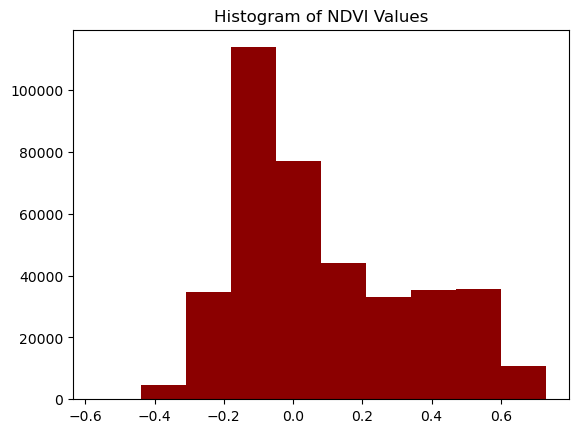

In [3]:
# Let's define a new figure
# The (1, 1) means we want one colum and one row, for a single plot (as opposed to a panel plot).
fig, ax1 = plt.subplots(1,1) 

# Let's get our data
ndvi_data = ndvi[numpy.not_equal(ndvi, my_image.nodata)]

# Specify the .hist() function to create the hist
ax1.hist(ndvi_data, color='darkred')

# We can state the title for this plot too
ax1.set_title('Histogram of NDVI Values')
